# NASA Data

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from wordcloud import WordCloud

## Get data
https://api.nasa.gov/

In [2]:
key = os.getenv("NASA_API")

In [3]:
url = "https://api.nasa.gov/techtransfer/patent/"
r = requests.get(url, {"api_key": key})
data = r.json()
patent = pd.DataFrame.from_records(
    data["results"],
    columns=[
        "unique_id",
        "designator1",
        "name",
        "description",
        "designator2",
        "category",
        "unk1",
        "unk2",
        "unk3",
        "source",
        "website",
        "unk4",
    ],
)

In [4]:
url = "https://api.nasa.gov/techtransfer/software/"
r = requests.get(url, {"api_key": key})
data = r.json()
software = pd.DataFrame.from_records(
    data["results"],
    columns=[
        "unique_id",
        "designator",
        "name",
        "description",
        "designator1",
        "category",
        "license",
        "unk1",
        "website",
        "source",
        "unk2",
        "unk3",
    ],
)

In [5]:
def create_description_wordcloud(df: pd.DataFrame):
    descriptions = [entry for entry in list(df["description"]) if len(entry) > 0]
    wordcloud = WordCloud().generate(" ".join(descriptions))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

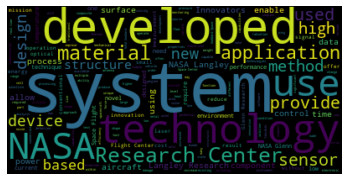

In [6]:
create_description_wordcloud(patent)

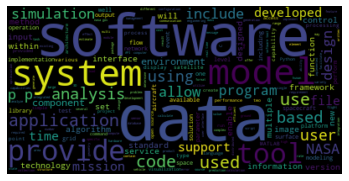

In [7]:
create_description_wordcloud(software)

## Who is getting these patents?

In [8]:
patent.groupby(["source"]).size().sort_values(ascending=False)

source
LARC    229
GSFC    140
ARC     109
GRC     101
MSFC     58
JSC      50
KSC      32
JPL      20
DFRC     19
SSC       5
dtype: int64

## And what for?

In [9]:
patent.groupby(["category"]).size().sort_values(ascending=False)

category
materials and coatings                 119
sensors                                102
aerospace                               79
mechanical and fluid systems            67
optics                                  58
electrical and electronics              44
information technology and software     43
manufacturing                           41
health medicine and biotechnology       40
robotics automation and control         35
instrumentation                         34
power generation and storage            33
communications                          29
environment                             24
propulsion                              12
undefined                                3
dtype: int64

## Where is NASA software hosted?

We'll look at the websites and break them down by hosting provider.

In [10]:
def top_level(url: str) -> str:
    search_strings = [".gov", ".com", ".org", ".net", ".io"]
    for search in search_strings:
        if search in url:
            return (
                (url.lstrip().split(search)[0] + search)
                .split("//")[-1]
                .replace("www.", "")
            )

In [11]:
def categorize_sources(urls: list):
    return [top_level(url) for url in urls]

In [12]:
data = dict(
    Counter(
        categorize_sources(
            [entry for entry in list(software["website"]) if len(entry) > 0]
        )
    ).most_common()
)
names = list(data.keys())
values = list(data.values())

In [13]:
def significant_labels(names, values):
    labels = []
    for i, e in enumerate(values):
        if (e / sum(values)) * 100 > 2:
            labels.append(names[i])
        else:
            labels.append("")
    return labels

In [14]:
def significant_autopct(pct):
    return ("%1.1f" % pct) if pct > 1 else ""

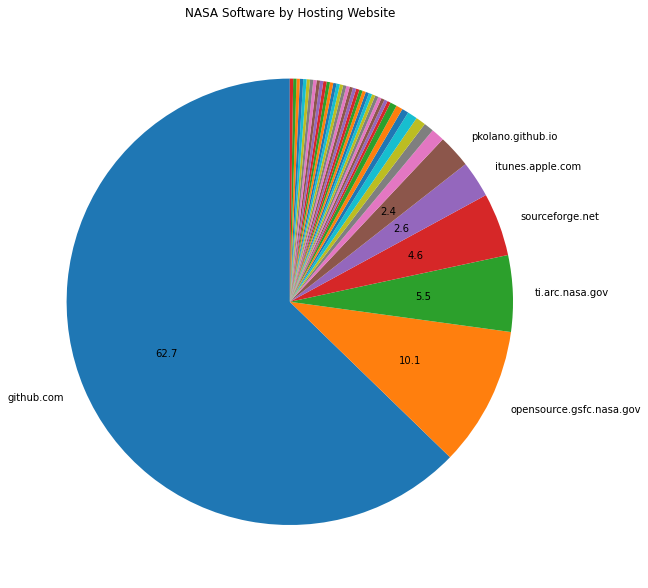

In [15]:
fig, ax = plt.subplots(figsize=(10, 20))
plt.pie(
    values,
    labels=significant_labels(names, values),
    autopct=significant_autopct,
    startangle=90,
)
plt.title("NASA Software by Hosting Website")
plt.show()